# Centroid Erraticity

How erratic is the centroid's motion over time? Does it become more or less chaotic?

We compute a rolling average of |ΔC′|₁ and measure deviations from that trend.

## Parameters

In [6]:
WINDOW_SIZE = 50  # Rolling average window
SMOOTHING_WINDOW = 100  # Window for smoothing erraticity itself
RANDOM_SEED = 42

## Imports

In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from safetensors.torch import load_file
from scipy.ndimage import uniform_filter1d

## Device Detection

In [8]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f"Using device: {device}")

Using device: mps


## Load Centroid Displacement Data

In [9]:
# Load ΔC′ from 1.31g
delta_C_prime_path = Path('../tensors/Thimble/1.31g_delta_C_prime.safetensors')
data = load_file(str(delta_C_prime_path))
delta_C_prime = data['delta_C_prime']  # [6000, 64]

print(f"Loaded ΔC′: {delta_C_prime.shape}")
print(f"dtype: {delta_C_prime.dtype}")

Loaded ΔC′: torch.Size([6000, 64])
dtype: torch.float32


## Compute L1 Norms

In [10]:
# L1 norm: sum of absolute values across all 64 dimensions
L1_norms = torch.abs(delta_C_prime).sum(dim=1).cpu().numpy()  # [6000]

print(f"L1 norms computed: {L1_norms.shape}")
print(f"Range: [{L1_norms.min():.2f}, {L1_norms.max():.2f}]")
print(f"Zeros: {(L1_norms == 0).sum()} / {len(L1_norms)} ({100 * (L1_norms == 0).sum() / len(L1_norms):.1f}%)")

L1 norms computed: (6000,)
Range: [0.00, 14935912448.00]
Zeros: 3671 / 6000 (61.2%)


## Compute Rolling Average

In [11]:
# Rolling average using uniform filter (handles edges by reflecting)
rolling_avg = uniform_filter1d(L1_norms, size=WINDOW_SIZE, mode='nearest')

print(f"Rolling average computed with window={WINDOW_SIZE}")

Rolling average computed with window=50


## Compute Erraticity

In [12]:
# Deviation from rolling average (absolute value)
erraticity = np.abs(L1_norms - rolling_avg)

# Smooth the erraticity itself to see long-term trends
erraticity_smoothed = uniform_filter1d(erraticity, size=SMOOTHING_WINDOW, mode='nearest')

print(f"Erraticity computed")
print(f"Mean erraticity: {erraticity.mean():.2f}")
print(f"Max erraticity: {erraticity.max():.2f}")

Erraticity computed
Mean erraticity: 16877794.00
Max erraticity: 7031551488.00


## Plot: Displacement and Rolling Average

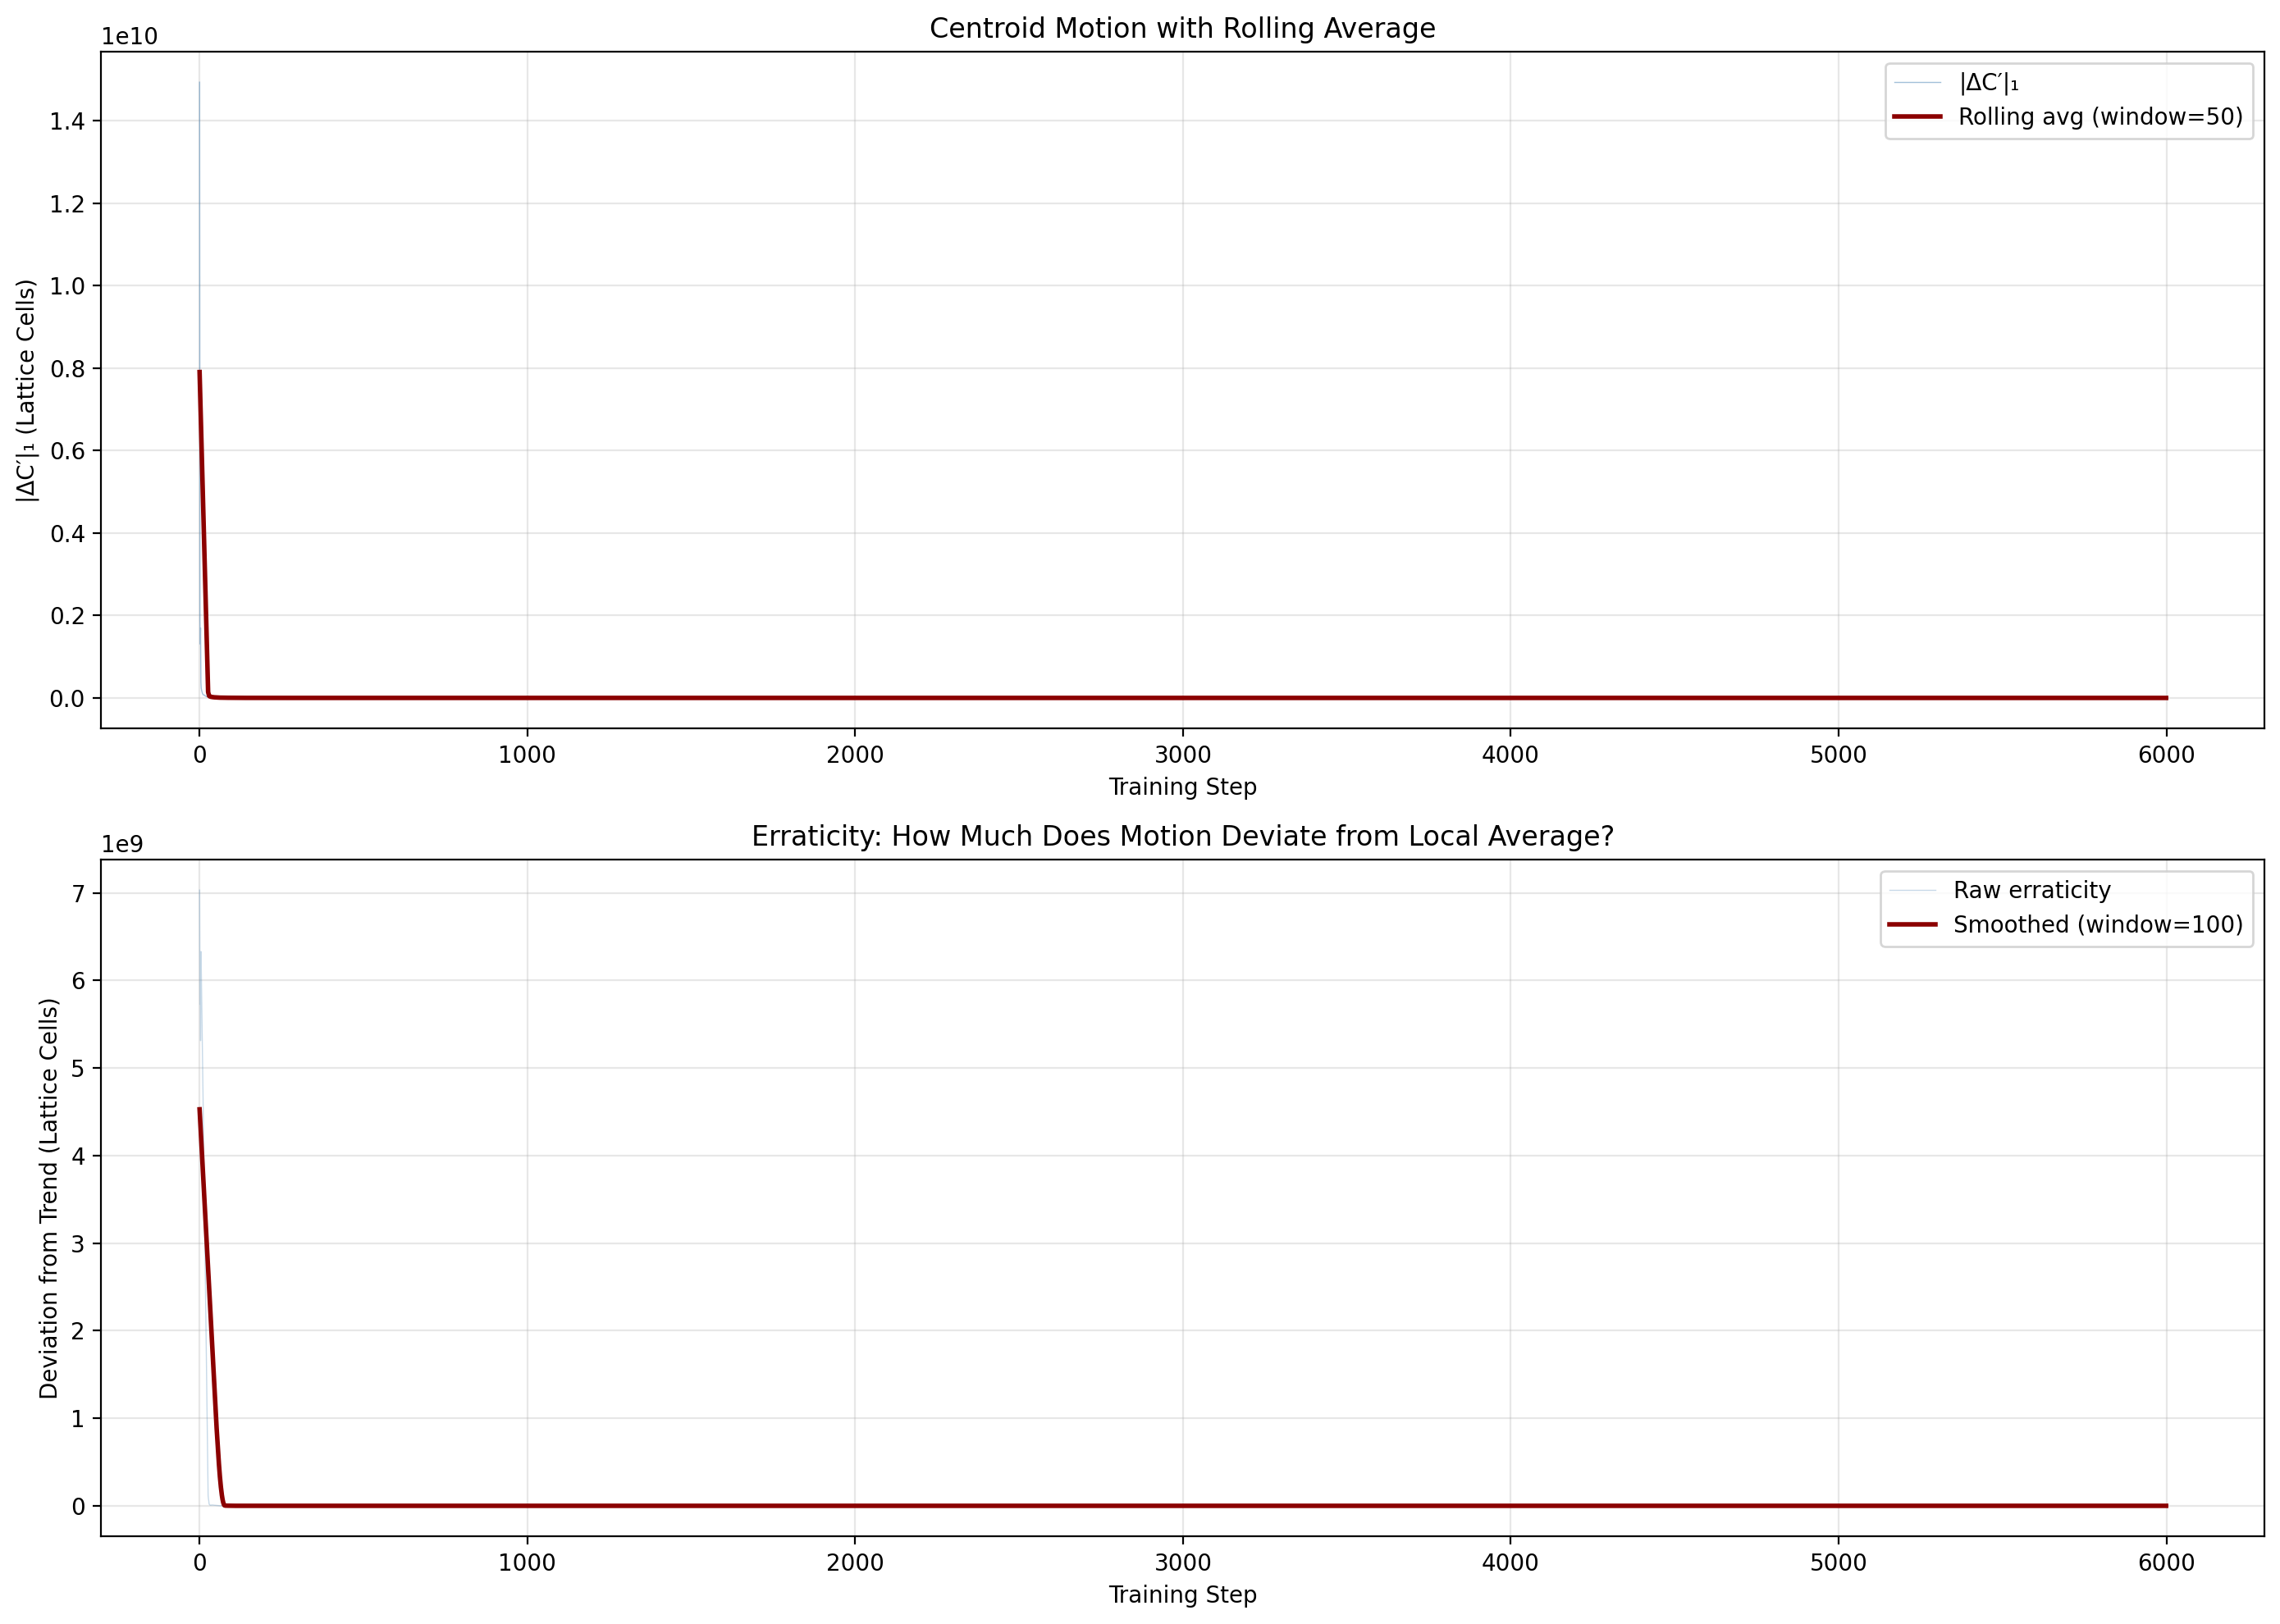

In [13]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), dpi=200)

# Top: L1 norm with rolling average
ax1.plot(L1_norms, color='steelblue', alpha=0.5, linewidth=0.5, label='|ΔC′|₁')
ax1.plot(rolling_avg, color='darkred', linewidth=2, label=f'Rolling avg (window={WINDOW_SIZE})')
ax1.set_xlabel('Training Step')
ax1.set_ylabel('|ΔC′|₁ (Lattice Cells)')
ax1.set_title('Centroid Motion with Rolling Average')
ax1.legend(loc='best')
ax1.grid(alpha=0.3)

# Bottom: Erraticity over time
ax2.plot(erraticity, color='steelblue', alpha=0.3, linewidth=0.5, label='Raw erraticity')
ax2.plot(erraticity_smoothed, color='darkred', linewidth=2, label=f'Smoothed (window={SMOOTHING_WINDOW})')
ax2.set_xlabel('Training Step')
ax2.set_ylabel('Deviation from Trend (Lattice Cells)')
ax2.set_title('Erraticity: How Much Does Motion Deviate from Local Average?')
ax2.legend(loc='best')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Summary Statistics

In [14]:
# Break into phases for analysis
# Early (0-500), Mid (500-2000), Late (2000+)
early_erraticity = erraticity[:500].mean()
mid_erraticity = erraticity[500:2000].mean()
late_erraticity = erraticity[2000:].mean()

print("=== Erraticity by Phase ===")
print(f"Early (t=0-500):     {early_erraticity:.2f}")
print(f"Mid (t=500-2000):    {mid_erraticity:.2f}")
print(f"Late (t=2000+):      {late_erraticity:.2f}")
print()
print(f"Early/Late ratio: {early_erraticity / late_erraticity:.2f}×")

=== Erraticity by Phase ===
Early (t=0-500):     202508896.00
Mid (t=500-2000):    7990.84
Late (t=2000+):      83.27

Early/Late ratio: 2432097.50×
